In [1]:
# general imports
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict
import pickle

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *
from helper.preprocess import *
from helper.custom_recommender import *

# keras
from keras import Input, Model
from keras.layers import Embedding, Reshape, Dot


# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\walke\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
df = pd.read_csv('../../merged_df.csv')

In [3]:

df = df[df['title'].notna()]

customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))

In [4]:
# select test size
n = 39601

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# split into train and test set
df_train = df[:-n]
df_test = df[-n:]

#### Predicting rating based on mean category

In [5]:
total_mean = df.overall.mean()

In [6]:
# fill nan categories
df_train[['categories']] = df_train[['categories']].fillna(value='unspecified')

# populate dictionary with cataegory and mean product rating
cat_rating_dict = dict(df_train.groupby('categories').mean()['overall'])

# apply the ratings to categories
df_train['cat_rat'] = df_train['categories'].apply(lambda x: cat_rating_dict[x])


# fill asin dict with asin and rating
asin_rating_dict = dict(df_train.groupby('asin').mean()['cat_rat'])

# apply rating per asin
df_train['asin_rating'] = df_train['asin'].apply(lambda x: asin_rating_dict[x])


# select testing dataframe
x = df_train[['reviewerID', 'overall', 'asin_rating']]

# calculate loss
rmse = np.sqrt(mean_squared_error(x['overall'], x['asin_rating']))
rmse

1.014438712052939

In [7]:
test = df_test[['reviewerID', 'overall', 'asin']]
test['asin_rating'] = test['asin'].apply(lambda x: asin_rating_dict.get(x, total_mean))

rmse = np.sqrt(mean_squared_error(test['overall'], test['asin_rating']))
rmse

1.0242521616956877

Text(0, 0.5, 'Count')

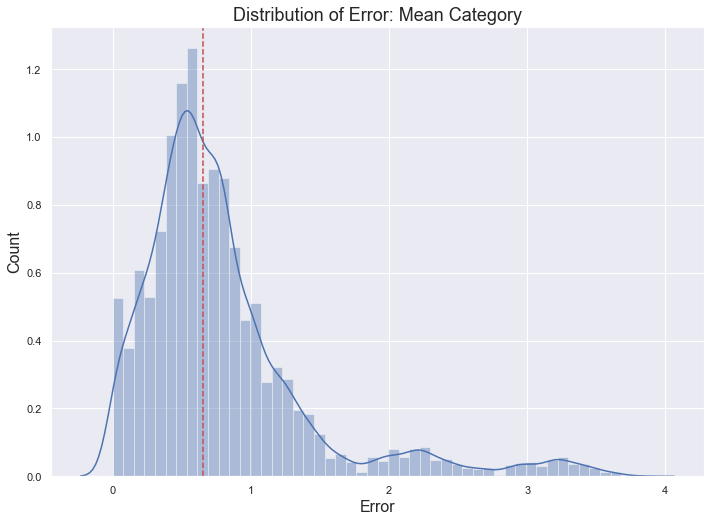

In [9]:
# lets look at the distribution of error
error = abs(test['overall'] - test['asin_rating'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Mean Category', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/mean_categories_error");

#### Rating prediction based on mean product rating
* This will be my baseline to beat in modeling

In [8]:
# populate dictionary with cataegory and mean product rating
asin_rating_dict = dict(df_train.groupby('asin').mean()['overall'])

# apply the ratings to categories
df_train['asin_rating'] = df_train['asin'].apply(lambda x: asin_rating_dict[x])

# select testing dataframe
x = df_train[['reviewerID', 'overall', 'asin_rating']]

# calculate loss
rmse = np.sqrt(mean_squared_error(x['overall'], x['asin_rating']))
rmse

0.9355252663730834

In [9]:
test = df_test[['reviewerID', 'overall', 'asin']]
test['asin_rating'] = test['asin'].apply(lambda x: asin_rating_dict.get(x, total_mean))

rmse = np.sqrt(mean_squared_error(test['overall'], test['asin_rating']))
rmse

1.00421418659535

Text(0, 0.5, 'Count')

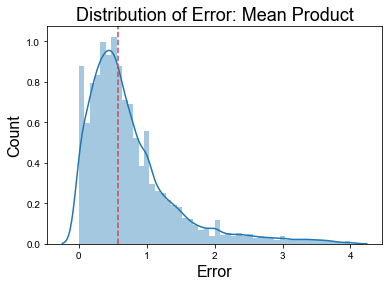

In [19]:
# lets look at the distribution of error
error = abs(test['overall'] - test['asin_rating'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Mean Product', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/mean_product_error");

##### train test split and set pivot table 

In [30]:
# create pivot table for correct reviewers and products
pivot_df = df.pivot_table(index='reviewerID', columns='asin', values='overall')

#### Recomender based on weighted averages
* This will be the baseline predictive model

In [31]:
# https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website
# min number of votes for weight (regularization)
min_number_of_votes = 20


# mean ratings of all products
mean_rating_all_products = pivot_df.stack().mean()


# mean rating per product
mean_rating_per_product = pivot_df.mean(axis=0).values


# rating cout for all products
rating_count_for_all_products = pivot_df.count().values



weighted_score = (rating_count_for_all_products / (rating_count_for_all_products + min_number_of_votes) * mean_rating_per_product) + \
(min_number_of_votes / (rating_count_for_all_products + min_number_of_votes) * mean_rating_all_products) 

In [32]:
weighted_rankings = np.argsort(weighted_score)[::-1]
weighted_rankings

array([3765, 4004, 1472, ..., 3250, 2466,  727], dtype=int64)

In [33]:
weighted_score = np.sort(weighted_score)[::-1]
weighted_score

array([4.7636734 , 4.74536593, 4.73946801, ..., 2.78292698, 2.56928449,
       2.4109227 ])

In [34]:
weighted_product_ids = pivot_df.columns[weighted_rankings]

In [35]:
product_df = df[['asin', 'imUrl']]

In [36]:
product_df

,asin,imUrl
0,B000HQ0L2E,http://ecx.images-amazon.com/images/I/313vMmXv...
1,B003FULBQ4,http://ecx.images-amazon.com/images/I/511Jshnt...
2,B0075X0Z46,http://ecx.images-amazon.com/images/I/31QsVepA...
3,B003UKM9CO,http://ecx.images-amazon.com/images/I/41ZOeb%2...
4,B004Q7CK4W,http://ecx.images-amazon.com/images/I/41fh85S0...
...,...,...
112905,B000Z8Z93K,http://ecx.images-amazon.com/images/I/5153EiTE...
112906,B00004YK10,http://ecx.images-amazon.com/images/I/41ptdc6T...
112907,B004VK5ON8,http://ecx.images-amazon.com/images/I/41eUU%2B...
112908,B001UNXE8G,http://ecx.images-amazon.com/images/I/41X9CgPt...


In [37]:
weighted_product_ids

Index(['B00AYE5EU8', 'B00DP5VX58', 'B001B13PC2', 'B0010JLMO8', 'B00GYSP2L4', 'B00HDPZCH6', 'B00JHKSKZQ', 'B00DGCWPAC', 'B00IT40BDA', 'B002EA99HE',
       ...
       'B005DDCKHK', 'B0087TNBUC', 'B00AW6YQVQ', 'B0096J28Z6', 'B00GY9DJCC', 'B0021AF9GC', 'B00AN5LADI', 'B006JKY3X0', 'B003KVO0GQ', 'B000GP1O4U'], dtype='object', name='asin', length=4342)

In [38]:
top_10 = weighted_product_ids[:10]

In [39]:
cold_dict = defaultdict(list)
for url in product_df[product_df.asin.isin(top_10)].drop_duplicates()['imUrl']:
    cold_dict['products'].append(url)

In [40]:
with open('cold_start.pickle', 'wb') as handle:
    pickle.dump(cold_dict, handle)

In [41]:
cold = open("cold_dict.pkl", "wb")
pickle.dump(cold_dict, cold)
cold.close()

In [42]:
cold_dict

defaultdict(list,
            {'products': ['http://ecx.images-amazon.com/images/I/31-lnE%2B7duL._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/41s5lXeFSUL._SX300_.jpg',
              'http://ecx.images-amazon.com/images/I/31rcxRGbhaL._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/41LrBoYpDNL._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/51goAhM0gOL._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/51wFa40jnSL._SX300_.jpg',
              'http://ecx.images-amazon.com/images/I/511-6ozJKHL._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/41IueSdjiML._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/41h%2BaXBoi1L._SY300_.jpg',
              'http://ecx.images-amazon.com/images/I/41hY7%2B2ZJuL._SY300_.jpg']})

In [9]:
weighted_product_ids.shape

(4342,)

In [12]:
df_preds = df_test.set_index('asin').join(pd.DataFrame(
    weighted_score, index=weighted_product_ids , columns=['Prediction'])
                                         )[['overall', 'Prediction']]

In [14]:
y_true = df_preds['overall']
y_pred = df_preds['Prediction']

y_pred.fillna(value=1, inplace=True)

In [15]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

1.007397682125784

Text(0, 0.5, 'Count')

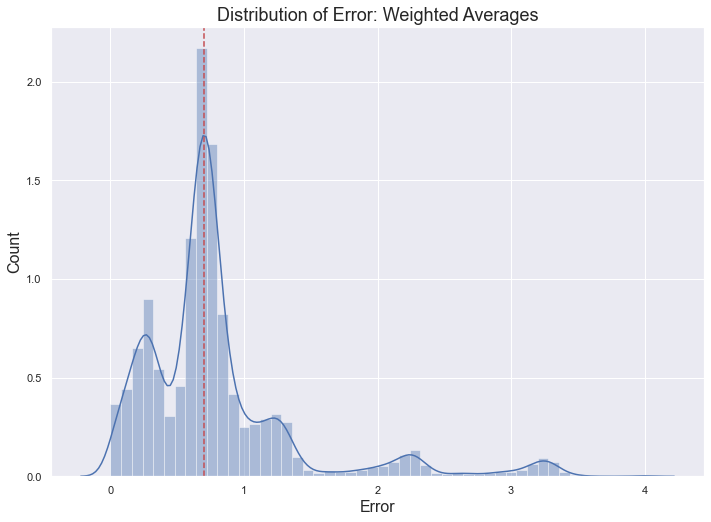

In [20]:
# lets look at the distribution of error
error = abs(df_preds['overall'] - df_preds['Prediction'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Weighted Averages', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/weighted_average_error");

#### What are my top 10 cold start recommendations?

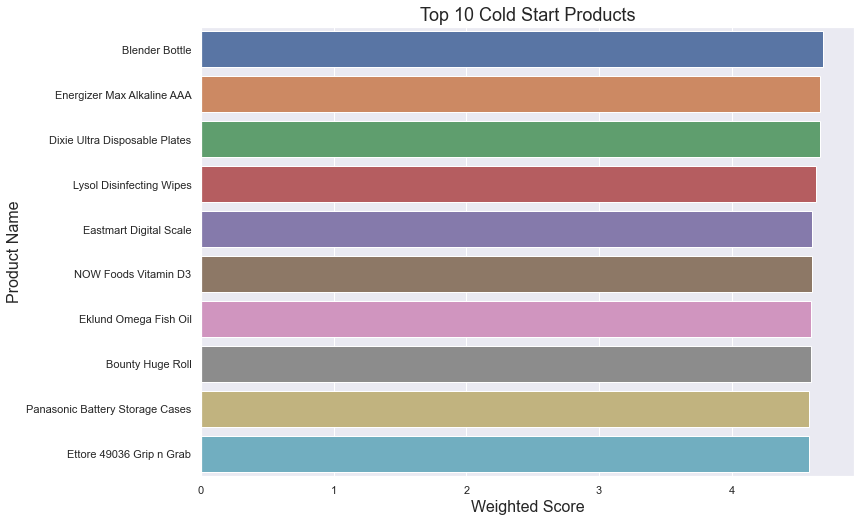

In [96]:
top_10 = weighted_score[:10]

top_10_reviewed_products = ['Blender Bottle', 'Energizer Max Alkaline AAA', 'Dixie Ultra Disposable Plates', 'Lysol Disinfecting Wipes', 'Eastmart Digital Scale',
                                 'NOW Foods Vitamin D3', 'Eklund Omega Fish Oil', 'Bounty Huge Roll', 
                                 'Panasonic Battery Storage Cases', 'Ettore 49036 Grip n Grab']

# idx_list = top_10_reviewed_apps.index.tolist()
figure = sns.barplot(x=top_10, y=top_10_reviewed_products)
plt.title('Top 10 Cold Start Products', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Weighted Score', fontsize=16)
plt.ylabel('Product Name', fontsize=16)
# plt.savefig(r"../images/top_10_coldstart");

##### Random Forest Product Recommender
* Building per item recommender with user NLP features

In [25]:
df = pd.read_csv('../../merged_df.csv')

In [26]:
df = df[df['title'].notna()]

# select reviewer and product values
customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))

In [27]:
model = custom_predictor(df)

In [28]:
model.fit(text_columns = ['summary'])

In [38]:
preds = model.predict_one(model = RandomForestRegressor(), product='159985130X')

0.6516666666666667


In [1]:
# preds = model.predict_all(model = RandomForestRegressor())